In [13]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt

class IzhikevichNetwork:
    def __init__(self, dt_val=1.0, T_total=1000, seed_val=42):
        """Parámetros globales de la simulación"""
        self.dt_val = dt_val
        self.T_total = T_total
        self.seed_val = seed_val
        
        # Configurar Brian2
        np.random.seed(seed_val)
        seed(seed_val)
        defaultclock.dt = dt_val * ms
        
        # Escalado para dt
        self.noise_scale = np.sqrt(dt_val)**(-1)
        
        # Contenedores
        self.populations = {}
        self.synapses = []
        self.monitors = {}
        
        # Parámetros heterogeneidad
        self.re = np.random.rand(800)
        self.ri = np.random.rand(200)
        
    def create_population(self, name, Ne=800, Ni=200, k_exc=0.5, k_inh=1.0, 
                         noise_exc=5.0, noise_inh=2.0, p_intra=1.0, delay = 0,  noise_type='gaussian'):
        """
        Crear una población Izhikevich
        
        Parameters:
        - name: identificador único
        - Ne, Ni: número de neuronas exc/inh
        - k_exc, k_inh: fuerza sináptica exc/inh
        - noise_exc, noise_inh: amplitud ruido talámico
        - p_intra: probabilidad conexión intra-población
        """
        
        # re = np.random.rand(Ne)
        # ri = np.random.rand(Ni)
        
        re = self.re
        ri = self.ri
        
        a_vals = np.concatenate([0.02*np.ones(Ne), 0.02+0.08*ri])
        b_vals = np.concatenate([0.2*np.ones(Ne), 0.25-0.05*ri])
        c_vals = np.concatenate([-65+15*re**2, -65*np.ones(Ni)])
        d_vals = np.concatenate([8-6*re**2, 2*np.ones(Ni)])
        
        # Ruido talámico
        time_steps = int(self.T_total / self.dt_val)
        
        if noise_type == 'gaussian':
            noise_exc_vals = np.random.randn(time_steps, Ne) * noise_exc * self.noise_scale
            noise_inh_vals = np.random.randn(time_steps, Ni) * noise_inh * self.noise_scale
            
        elif noise_type == 'poisson':
            dt_ms = self.dt_val  # dt en ms
            lambda_exc = noise_exc**2 / dt_ms  # std target = 5.0
            lambda_inh = noise_inh**2 / dt_ms   # std target = 2.0
            
            # Poisson con rate proporcional a noise_exc/inh
            noise_exc_vals = np.random.poisson(lambda_exc, (time_steps, Ne)) - lambda_exc
            noise_inh_vals = np.random.poisson(lambda_inh, (time_steps, Ni)) - lambda_inh
        
        
        noise_combined = np.concatenate([noise_exc_vals, noise_inh_vals], axis=1)
        stimulus = TimedArray(noise_combined, dt=self.dt_val*ms)
        
        # Ecuaciones neurales
        eqs = f'''
        dv/dt = (0.04*v**2 + 5*v + 140 - u + I_syn + I_thalamic) / ms : 1
        du/dt = a*(b*v - u) / ms : 1
        I_syn : 1
        I_accum : 1
        I_thalamic = stimulus_{name}(t, i) : 1
        a : 1 (constant)
        b : 1 (constant) 
        c : 1 (constant)
        d : 1 (constant)
        '''
        
        # Crear grupo neuronal
        G = NeuronGroup(Ne + Ni, eqs, threshold='v >= 30', 
                    reset='v = c; u += d', method='heun',
                    namespace={f'stimulus_{name}': stimulus})
        
        # Asignar parámetros
        G.a = a_vals
        G.b = b_vals
        G.c = c_vals
        G.d = d_vals
        G.v = -65 + 5*np.random.randn(Ne + Ni) 
        G.u = G.b * G.v
        G.I_syn = 0
        G.I_accum = 0
        
        # Sinapsis intra-población
        syn_intra = Synapses(G, G, 'w : 1', on_pre='I_accum_post += w')
        syn_intra.connect(p=p_intra)
        syn_intra.delay = delay*ms
        
        # Generar pesos solo para conexiones existentes
        n_connections = len(syn_intra.i)
        n_exc_connections = np.sum(syn_intra.i < Ne)  # Conexiones desde excitatorias
        n_inh_connections = n_connections - n_exc_connections
        
        # Asignar pesos según tipo de conexión
        weights = np.zeros(n_connections)
        weights[:n_exc_connections] = k_exc * np.random.rand(n_exc_connections)  # Exc weights
        weights[n_exc_connections:] = -k_inh * np.random.rand(n_inh_connections)  # Inh weights

        syn_intra.w = weights
    
        # Guardar población
        self.populations[name] = {
            'group': G,
            'Ne': Ne,
            'Ni': Ni,
            'syn_intra': syn_intra,
            'stimulus': stimulus
        }
        
        self.synapses.append(syn_intra)
        
        return G
    
    def connect_populations(self, source_name, target_name, p_inter=0.01, 
                       weight_scale=4.0, weight_dist='constant', weight_params=None,
                        delay_value=0.0, delay_dist='constant', delay_params=None):
        """
        Conectar poblaciones con distribuciones configurables
        
        Parameters:
        - weight_dist: 'constant', 'uniform', 'gaussian', 'beta'
        - weight_params: dict con parámetros de distribución
        - delay_dist: 'constant', 'uniform', 'gaussian', 'beta'  
        - delay_params: dict con parámetros de distribución
        """
        
        source = self.populations[source_name]['group']
        target = self.populations[target_name]['group']
        source_Ne = self.populations[source_name]['Ne']
        target_Ne = self.populations[target_name]['Ne']
        
        # Solo conexiones excitatorias inter-población
        syn_inter = Synapses(source[:source_Ne], target, 'w : 1', 
                            on_pre='I_accum_post += w')
        syn_inter.connect(p=p_inter*1.25) # factor 1.25 para compensar que las conexiones solo salen de excitatorias y queremos p ~ 10 : 1 (intra/inter)
        
        # Pesos y delays
        # Generar pesos según distribución
        n_conn = len(syn_inter)
        k_base = 0.5
         
        if weight_dist == 'constant':
            weights = np.ones(n_conn)
        elif weight_dist == 'uniform':
            low, high = weight_params.get('low', 0), weight_params.get('high', 1)
            weights = np.random.uniform(low, high, n_conn)
        # elif weight_dist == 'gaussian':
        #     mu, sigma = weight_params.get('mu', 1), weight_params.get('sigma', 0.1)
        #     weights = np.random.normal(mu, sigma, n_conn)
        # elif weight_dist == 'beta':
        #     alpha, beta = weight_params.get('alpha', 2), weight_params.get('beta', 2)
        #     weights = np.random.beta(alpha, beta, n_conn)
        
        syn_inter.w = weight_scale * k_base * weights
        
        # Generar delays según distribución
        if delay_dist == 'constant':
            delays = delay_value * np.ones(n_conn)
        elif delay_dist == 'uniform':
            low, high = delay_params.get('low', 0.2), delay_params.get('high', 6.0)
            delays = np.random.uniform(low, high, n_conn)
        elif delay_dist == 'gaussian':
            mu, sigma = delay_params.get('mu', 3.0), delay_params.get('sigma', 1.0)
            delays = np.clip(np.random.normal(mu, sigma, n_conn), 0.1, None)
        elif delay_dist == 'beta':
            alpha, beta = delay_params.get('alpha', 2), delay_params.get('beta', 2)
            scale = delay_params.get('scale', 10)
            delays = scale * np.random.beta(alpha, beta, n_conn)
        
        syn_inter.delay = delays * ms
        
        self.synapses.append(syn_inter)
        
        return syn_inter
    
    def setup_monitors(self, population_names):
        """Configurar monitores para poblaciones especificadas"""
        
        for name in population_names:
            G = self.populations[name]['group']
            Ne = self.populations[name]['Ne']
            
            # Monitores
            spike_mon = SpikeMonitor(G)
            state_mon = StateMonitor(G, ['v', 'I_syn', 'I_thalamic'], 
                                record=range(0, min(100, Ne)))
            
            self.monitors[name] = {
                'spikes': spike_mon,
                'states': state_mon
            }
    
    def run_simulation(self):
        """Ejecutar simulación completa"""
        
        # Operación de red para aplicación sináptica
        @network_operation(dt=1.0*ms, when='before_groups')
        def apply_synapses():
            for pop_data in self.populations.values():
                G = pop_data['group']
                G.I_syn = G.I_accum
                G.I_accum = 0
        
        # Crear red explícita
        net_objects = []
        
        # Añadir poblaciones
        for pop_data in self.populations.values():
            net_objects.append(pop_data['group'])
        
        # Añadir sinapsis
        net_objects.extend(self.synapses)
        
        # Añadir monitores
        for mon_data in self.monitors.values():
            net_objects.extend(mon_data.values())
        
        # Añadir operación de red
        net_objects.append(apply_synapses)
        
        # Ejecutar
        net = Network(*net_objects)
        net.run(self.T_total * ms)
        
        return self.get_results()
    
    def get_results(self, warmup_time=200):
        """Extraer resultados excluyendo período de warmup"""
        results = {}
        
        for name, monitors in self.monitors.items():
            # Filtrar spikes
            spike_mask = monitors['spikes'].t >= warmup_time*ms
            spike_times_filtered = monitors['spikes'].t[spike_mask] / ms
            spike_indices_filtered = monitors['spikes'].i[spike_mask]
            
            # Filtrar estados (solo axis temporal)
            state_mask = monitors['states'].t >= warmup_time*ms
            times_filtered = monitors['states'].t[state_mask] / ms
            
            results[name] = {
                'spike_monitor': monitors['spikes'],
                'state_monitor': monitors['states'], 
                'spike_times': np.array(spike_times_filtered),
                'spike_indices': np.array(spike_indices_filtered),
                'potentials': np.array(monitors['states'].v)[:, state_mask],  # Fix: slice time axis
                'I_syn': np.array(monitors['states'].I_syn)[:, state_mask],
                'I_thalamic': np.array(monitors['states'].I_thalamic)[:, state_mask],
                'times': np.array(times_filtered)
            }
        
        results['dt'] = self.dt_val
        results['T_total'] = self.T_total - warmup_time
        
        return results

WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:549: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]
WARNING    /home/ubuntu-deduce/Projects/izhikevich/src/two_populations/metrics.py:648: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
 [py.warnings]


nperseg=600, noverlap=150, len(signal_A)=4800

=== Análisis de Conectividad - Baseline ===
Cross-correlation peak: 0.590 at 5.8ms
PLV Alpha: 0.410
PLI Alpha: 0.399
PLV Gamma: 0.194
PLI Gamma: 0.194
Coherence peak: 0.679 at 0.0Hz
Intrinsic timescales: Pop A = 5.4ms (poor), Pop B = 9.5ms (moderate)


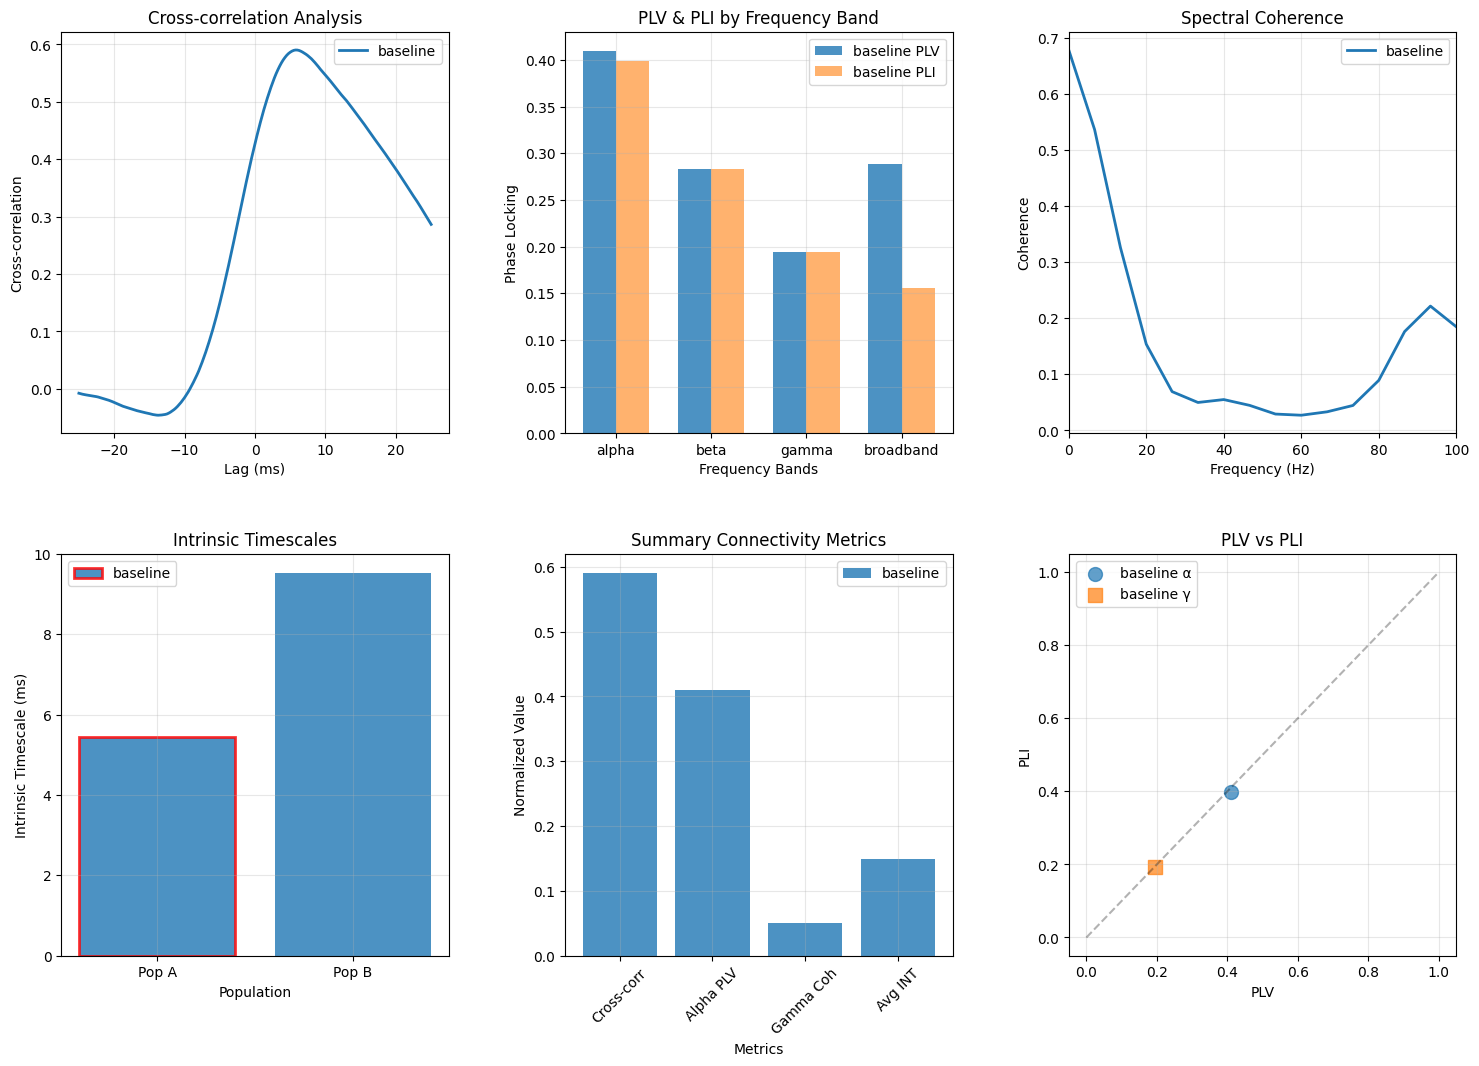

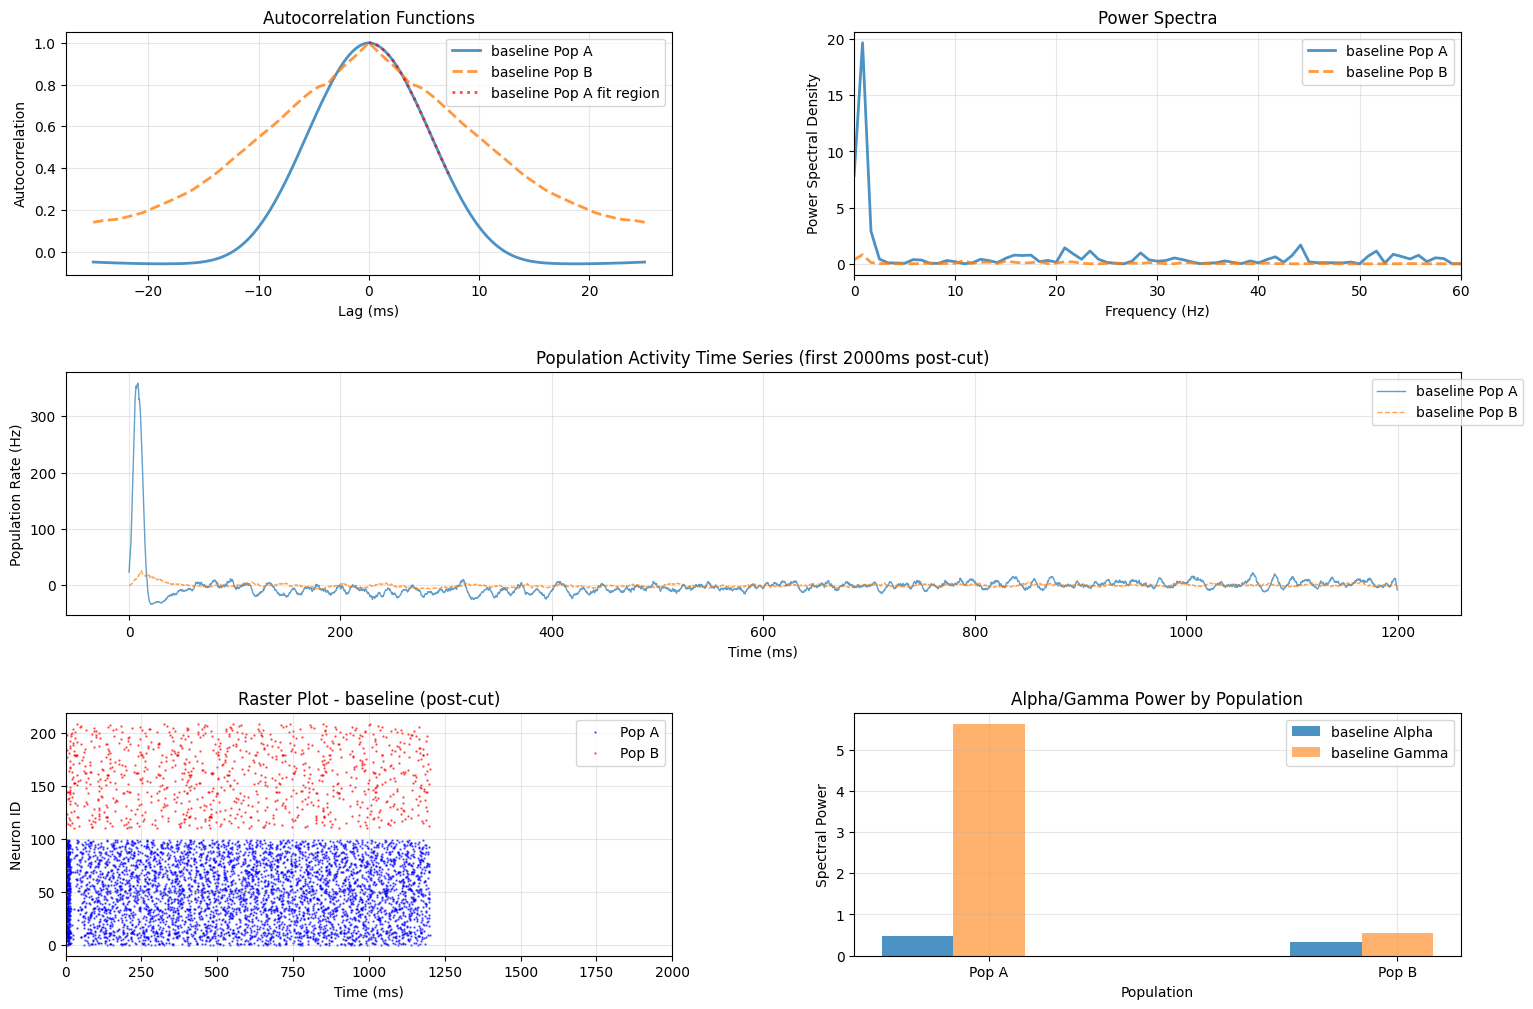

In [ ]:
import os

os.chdir("../..")


from src.two_populations.metrics import plot_connectivity_dashboard, analyze_simulation_results, plot_population_dashboard

start_scope()

k_factor = 4.0

# Crear simulador
sim = IzhikevichNetwork(dt_val=0.01, T_total=1200, seed_val=42)

# === POBLACIÓN A: MAESTRO (más excitable) ===
pop_A = sim.create_population('A', Ne=800, Ni=200, 
                             k_exc=k_factor*0.6, k_inh=k_factor*0.8,
                             noise_exc=15.0,  # MÁS ruido → más actividad
                             noise_inh=4.0, 
                             p_intra=0.1, delay=1.0,
                             noise_type='poisson')

# === POBLACIÓN B: ESCLAVO (menos excitable) ===
pop_B = sim.create_population('B', Ne=800, Ni=200,
                             k_exc=k_factor*0.6, k_inh=k_factor*0.8,
                             noise_exc=5.0,  # MENOS ruido → sigue a A
                             noise_inh=1.0,
                             p_intra=0.1, delay=1.0,
                             noise_type='poisson')

# === CONEXIONES ASIMÉTRICAS ===
# A→B: FUERTE y con delay específico
# syn_AB = sim.connect_populations('A', 'B', p_inter=0.02,  # Más conexiones
#                                 weight_scale=k_factor*4.0,  # Fuerte
#                                 delay_value=20.0)  # Delay específico

# # B→A: DÉBIL y con delay diferente
# syn_BA = sim.connect_populations('B', 'A', p_inter=0.005,  # Menos conexiones  
#                                 weight_scale=k_factor*0.05,  # Débil
#                                 delay_value=3.0)   # Delay corto


# Configurar monitores
sim.setup_monitors(['A', 'B'])
results = sim.run_simulation()

results_dict = {}

# Una línea para analizar
results_dict = {
    'baseline': analyze_simulation_results(results['A']['spike_monitor'], results['B']['spike_monitor'], 1000, "Baseline")
}

# Dashboard
fig1 = plot_connectivity_dashboard(results_dict)  # Principal
fig2 = plot_population_dashboard(results_dict)    # Detallado

In [15]:
from src.two_populations.metrics import print_network_statistics_table

print_network_statistics_table(results, sim, 800, 200, 1200, 200)

    DEBUG: CV_individual=0.299, CV_population=0.085
    DEBUG: CV_individual=0.324, CV_population=0.180

COMPARACIÓN ESTADÍSTICAS DE RED (Post-warmup 200ms)
Métrica                   Población A               Población B              
---------------------------------------------------------------------------
ARQUITECTURA             
  Conexiones              99776                     100135
  Prob. conexión          0.0999                      0.1002
  Sparsity                0.900                       0.900

ACTIVIDAD                
  Freq exc (Hz)           39.61                        8.20
  Freq inh (Hz)           40.89                        5.10
  Ratio E/I               0.97                        1.61
  Activas exc (%)         100.0                         100.0
  Activas inh (%)         100.0                         64.0

SINCRONÍA                
  CV                      0.299                       0.324
  Fano Factor             0.287                       0.264
  Nivel

{'A': {'connections': 99776,
  'conn_prob': 0.09987587587587587,
  'sparsity': 0.9001241241241241,
  'freq_exc': np.float64(39.61),
  'freq_inh': np.float64(40.89),
  'ratio_ei': np.float64(0.9686965028124236),
  'active_exc_pct': np.float64(100.0),
  'active_inh_pct': np.float64(100.0),
  'cv': np.float64(0.29850630432399317),
  'fano': np.float64(0.28726761760816166),
  'sync_level': 'Alta',
  'burst_rate': 5.0,
  'burst_duration': np.float64(1.0),
  'burst_coverage': np.float64(0.5),
  'exc_weight_mean': np.float64(1.9394030904374708),
  'exc_weight_std': np.float64(0.8791869738614533),
  'inh_weight_mean': np.float64(0.6300722427441995),
  'inh_weight_std': np.float64(0.8791869738614531)},
 'B': {'connections': 100135,
  'conn_prob': 0.10023523523523524,
  'sparsity': 0.8997647647647647,
  'freq_exc': np.float64(8.2),
  'freq_inh': np.float64(5.1),
  'ratio_ei': np.float64(1.607843137254902),
  'active_exc_pct': np.float64(100.0),
  'active_inh_pct': np.float64(64.0),
  'cv': np.fl

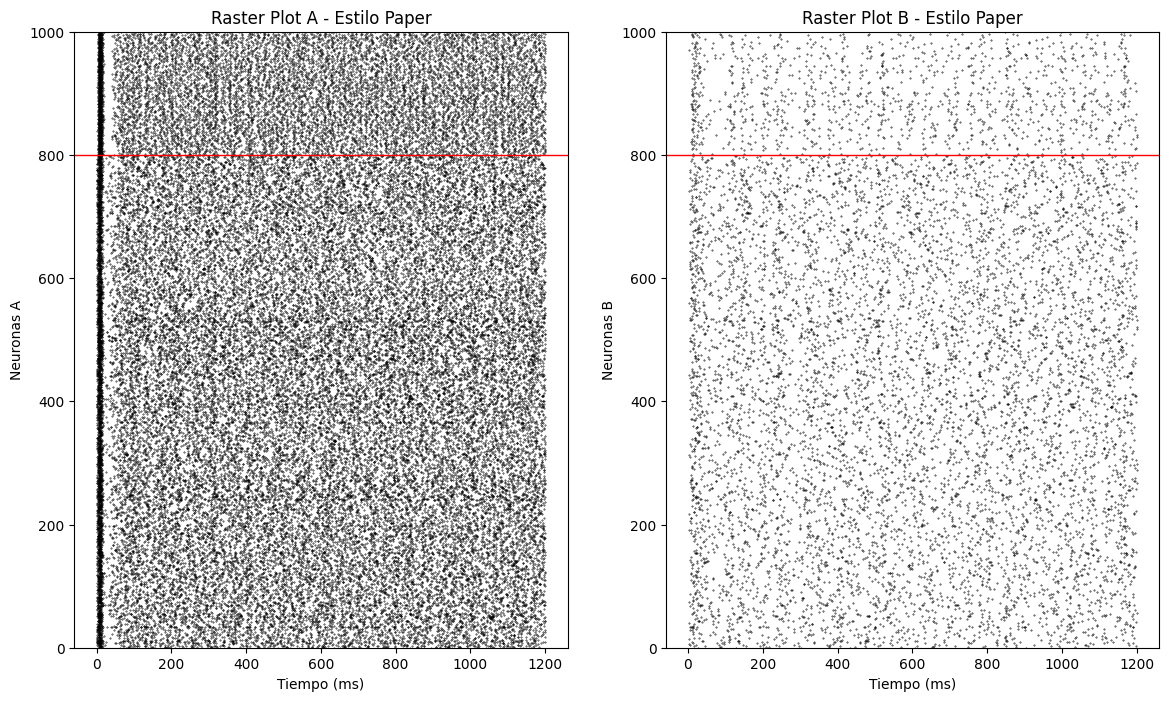

In [16]:
def plot_raster_results(results, N_exc=800, N_total=1000):
   """Graficar raster plots usando resultados de la clase"""
   figure(figsize=(14, 8))

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   
   # Separar exc/inh por índices
   exc_mask_A = spike_mon_A.i < N_exc
   inh_mask_A = spike_mon_A.i >= N_exc
   
   plot(spike_mon_A.t[exc_mask_A]/ms, spike_mon_A.i[exc_mask_A], '.k', markersize=0.7)
   plot(spike_mon_A.t[inh_mask_A]/ms, spike_mon_A.i[inh_mask_A], '.k', markersize=0.7)
   axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel('Neuronas A')
   title('Raster Plot A - Estilo Paper')
   ylim(0, N_total)

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   
   exc_mask_B = spike_mon_B.i < N_exc
   inh_mask_B = spike_mon_B.i >= N_exc
   
   plot(spike_mon_B.t[exc_mask_B]/ms, spike_mon_B.i[exc_mask_B], '.k', markersize=0.7)
   plot(spike_mon_B.t[inh_mask_B]/ms, spike_mon_B.i[inh_mask_B], '.k', markersize=0.7)
   axhline(y=N_exc, color='r', linestyle='-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel('Neuronas B')
   title('Raster Plot B - Estilo Paper')
   ylim(0, N_total)
   
   show()
   
plot_raster_results(results)

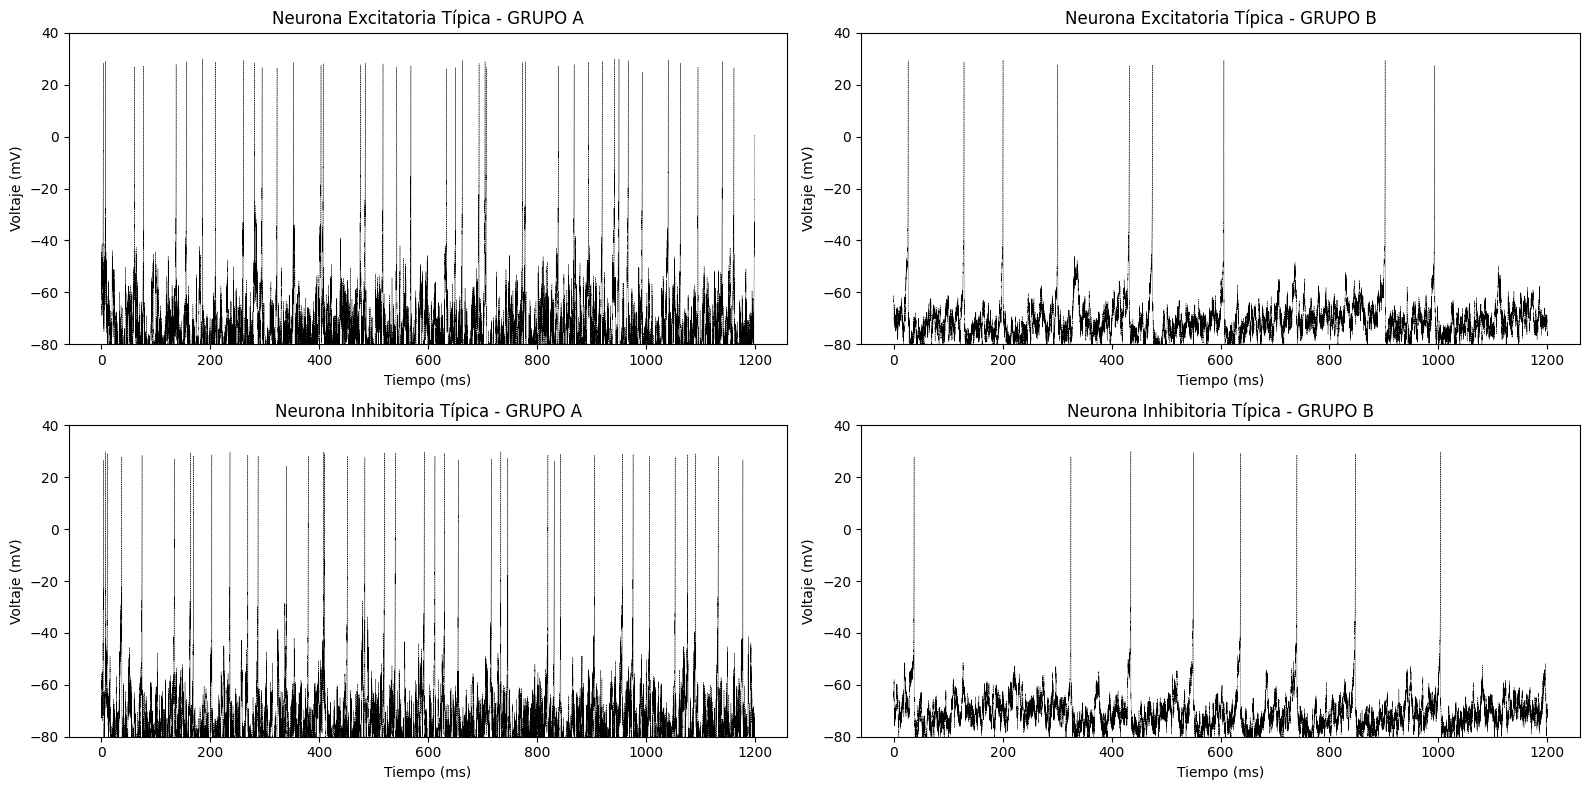

In [17]:
def plot_voltage_traces(results, N_exc=800, neuron_idx=0):
    """Graficar trazas de voltaje usando resultados de la clase"""
    figure(figsize=(16, 8))

    # Grupo A - Excitatoria
    subplot(2, 2, 1)
    state_mon_A = results['A']['state_monitor']
    plot(state_mon_A.t/ms, state_mon_A.v[neuron_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Excitatoria Típica - GRUPO A')
    ylim(-80, 40)

    # Grupo B - Excitatoria
    subplot(2, 2, 2)
    state_mon_B = results['B']['state_monitor']
    plot(state_mon_B.t/ms, state_mon_B.v[neuron_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Excitatoria Típica - GRUPO B')
    ylim(-80, 40)

    # Grupo A - Inhibitoria (usar neurona dentro del rango registrado)
    subplot(2, 2, 3)
    inh_idx = min(99, N_exc + neuron_idx)  # Limitar al rango disponible
    if len(state_mon_A.v) > inh_idx:
        plot(state_mon_A.t/ms, state_mon_A.v[inh_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Inhibitoria Típica - GRUPO A')
    ylim(-80, 40)

    # Grupo B - Inhibitoria
    subplot(2, 2, 4)
    if len(state_mon_B.v) > inh_idx:
        plot(state_mon_B.t/ms, state_mon_B.v[inh_idx], '--', linewidth=0.3, color='black')
    xlabel('Tiempo (ms)')
    ylabel('Voltaje (mV)')
    title('Neurona Inhibitoria Típica - GRUPO B')
    ylim(-80, 40)

    tight_layout()
    show()
   
plot_voltage_traces(results)

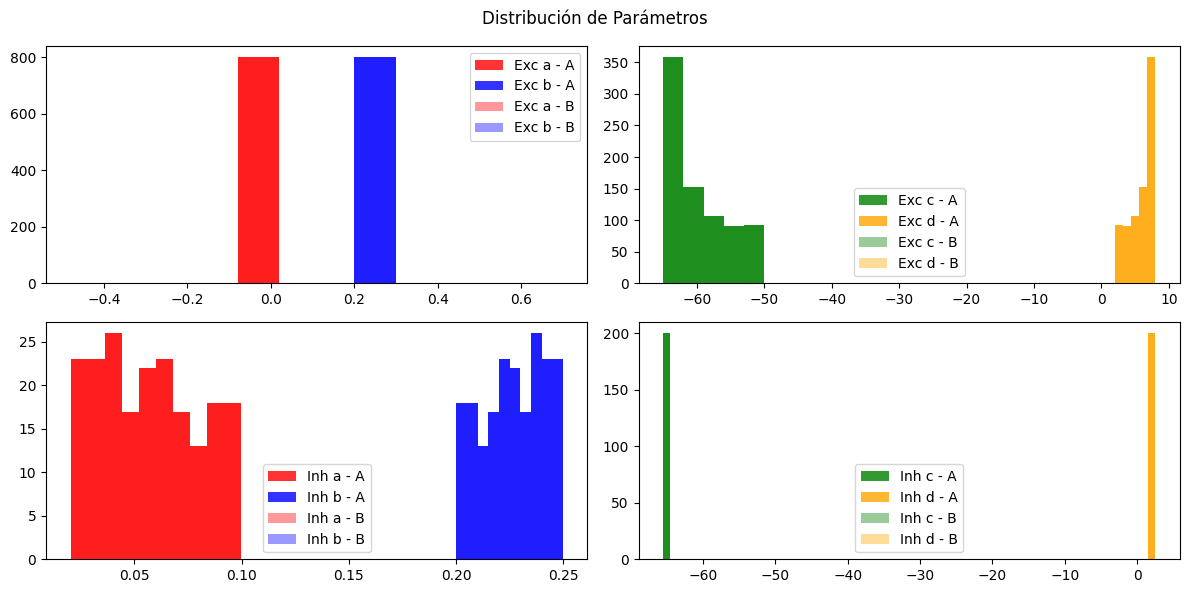

In [18]:
def plot_parameter_distributions(pop_A, pop_B, N_exc=800):
   """Graficar distribuciones de parámetros usando objetos de la red"""
   figure(figsize=(12, 6))
   suptitle('Distribución de Parámetros')

   # Extraer grupos
   group_A = pop_A
   group_B = pop_B
   
   # Separar parámetros exc/inh
   a_exc_A, a_inh_A = group_A.a[:N_exc], group_A.a[N_exc:]
   b_exc_A, b_inh_A = group_A.b[:N_exc], group_A.b[N_exc:]
   c_exc_A, c_inh_A = group_A.c[:N_exc], group_A.c[N_exc:]
   d_exc_A, d_inh_A = group_A.d[:N_exc], group_A.d[N_exc:]
   
   a_exc_B, a_inh_B = group_B.a[:N_exc], group_B.a[N_exc:]
   b_exc_B, b_inh_B = group_B.b[:N_exc], group_B.b[N_exc:]
   c_exc_B, c_inh_B = group_B.c[:N_exc], group_B.c[N_exc:]
   d_exc_B, d_inh_B = group_B.d[:N_exc], group_B.d[N_exc:]

   # Parámetros excitatorios a,b
   subplot(2, 2, 1)
   hist(a_exc_A, alpha=0.8, color='red', bins=10, label='Exc a - A')
   hist(b_exc_A, alpha=0.8, color='blue', bins=10, label='Exc b - A')
   hist(a_exc_B, alpha=0.4, color='red', bins=10, label='Exc a - B')
   hist(b_exc_B, alpha=0.4, color='blue', bins=10, label='Exc b - B')
   legend()

   # Parámetros excitatorios c,d
   subplot(2, 2, 2)
   hist(c_exc_A, alpha=0.8, color='green', bins=5, label='Exc c - A')
   hist(d_exc_A, alpha=0.8, color='orange', bins=5, label='Exc d - A')
   hist(c_exc_B, alpha=0.4, color='green', bins=5, label='Exc c - B')
   hist(d_exc_B, alpha=0.4, color='orange', bins=5, label='Exc d - B')
   legend()

   # Parámetros inhibitorios a,b
   subplot(2, 2, 3)
   hist(a_inh_A, alpha=0.8, color='red', bins=10, label='Inh a - A')
   hist(b_inh_A, alpha=0.8, color='blue', bins=10, label='Inh b - A')
   hist(a_inh_B, alpha=0.4, color='red', bins=10, label='Inh a - B')
   hist(b_inh_B, alpha=0.4, color='blue', bins=10, label='Inh b - B')
   legend()

   # Parámetros inhibitorios c,d
   subplot(2, 2, 4)
   hist(c_inh_A, alpha=0.8, color='green', bins=1, label='Inh c - A')
   hist(d_inh_A, alpha=0.8, color='orange', bins=1, label='Inh d - A')
   hist(c_inh_B, alpha=0.4, color='green', bins=1, label='Inh c - B')
   hist(d_inh_B, alpha=0.4, color='orange', bins=1, label='Inh d - B')
   legend()

   tight_layout()
   show()
   
plot_parameter_distributions(pop_A, pop_B)

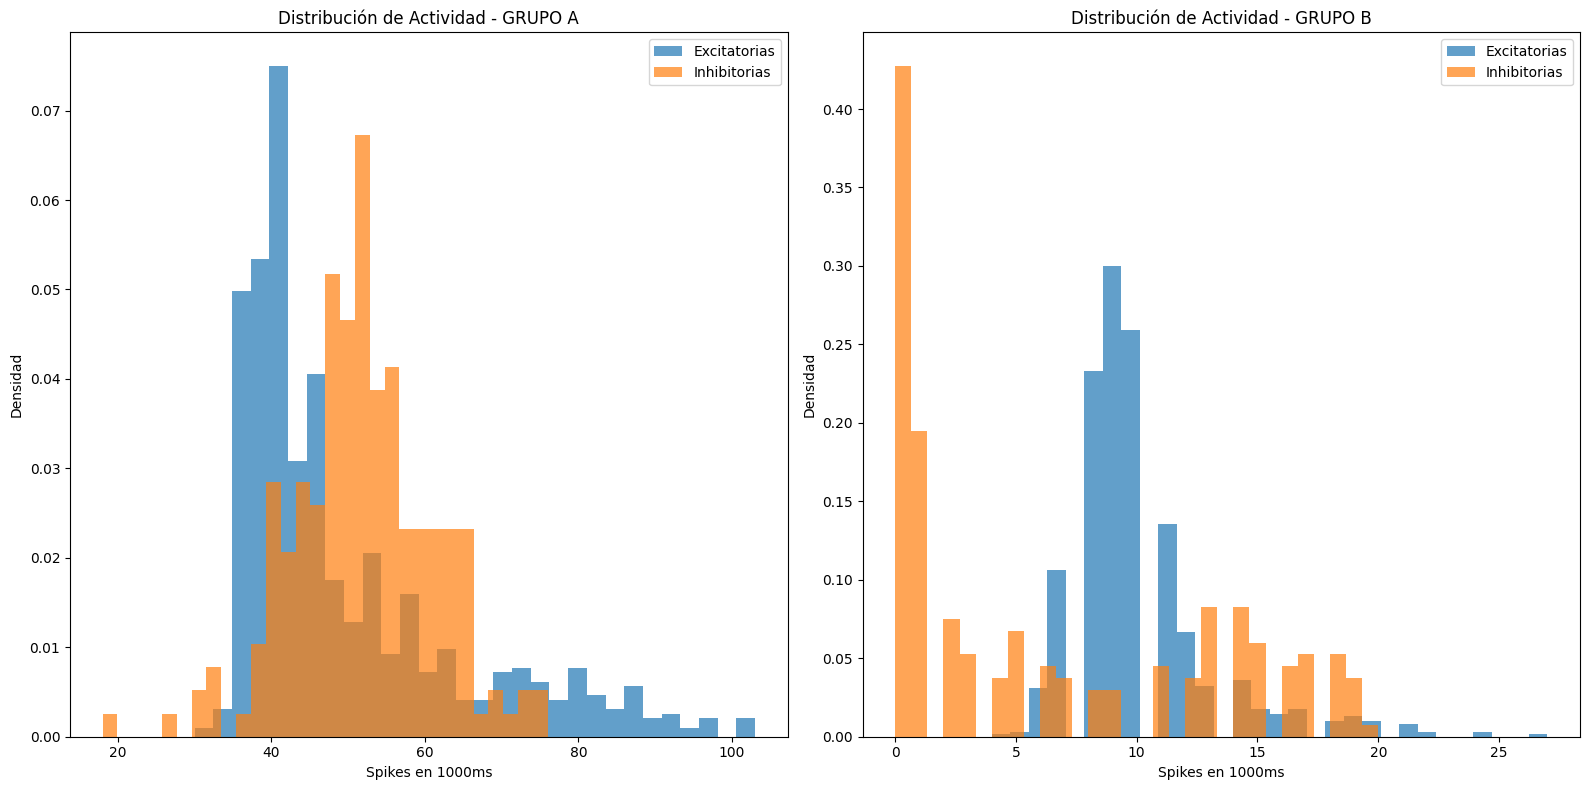

In [19]:
def plot_activity_distributions(results, N_exc=800, N_inh=200):
   """Graficar distribuciones de actividad usando resultados de la red"""
   figure(figsize=(16, 8))

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   
   # Contar spikes por neurona
   freq_exc_A = [sum(spike_mon_A.i == i) for i in range(N_exc)]
   freq_inh_A = [sum(spike_mon_A.i == (i + N_exc)) for i in range(N_inh)]

   hist(freq_exc_A, bins=30, alpha=0.7, density=True, label='Excitatorias')
   hist(freq_inh_A, bins=30, alpha=0.7, density=True, label='Inhibitorias')
   xlabel('Spikes en 1000ms')
   ylabel('Densidad')
   title('Distribución de Actividad - GRUPO A')
   legend()

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   
   freq_exc_B = [sum(spike_mon_B.i == i) for i in range(N_exc)]
   freq_inh_B = [sum(spike_mon_B.i == (i + N_exc)) for i in range(N_inh)]

   hist(freq_exc_B, bins=30, alpha=0.7, density=True, label='Excitatorias')
   hist(freq_inh_B, bins=30, alpha=0.7, density=True, label='Inhibitorias')
   xlabel('Spikes en 1000ms')
   ylabel('Densidad')
   title('Distribución de Actividad - GRUPO B')
   legend()

   tight_layout()
   show()
   
plot_activity_distributions(results)

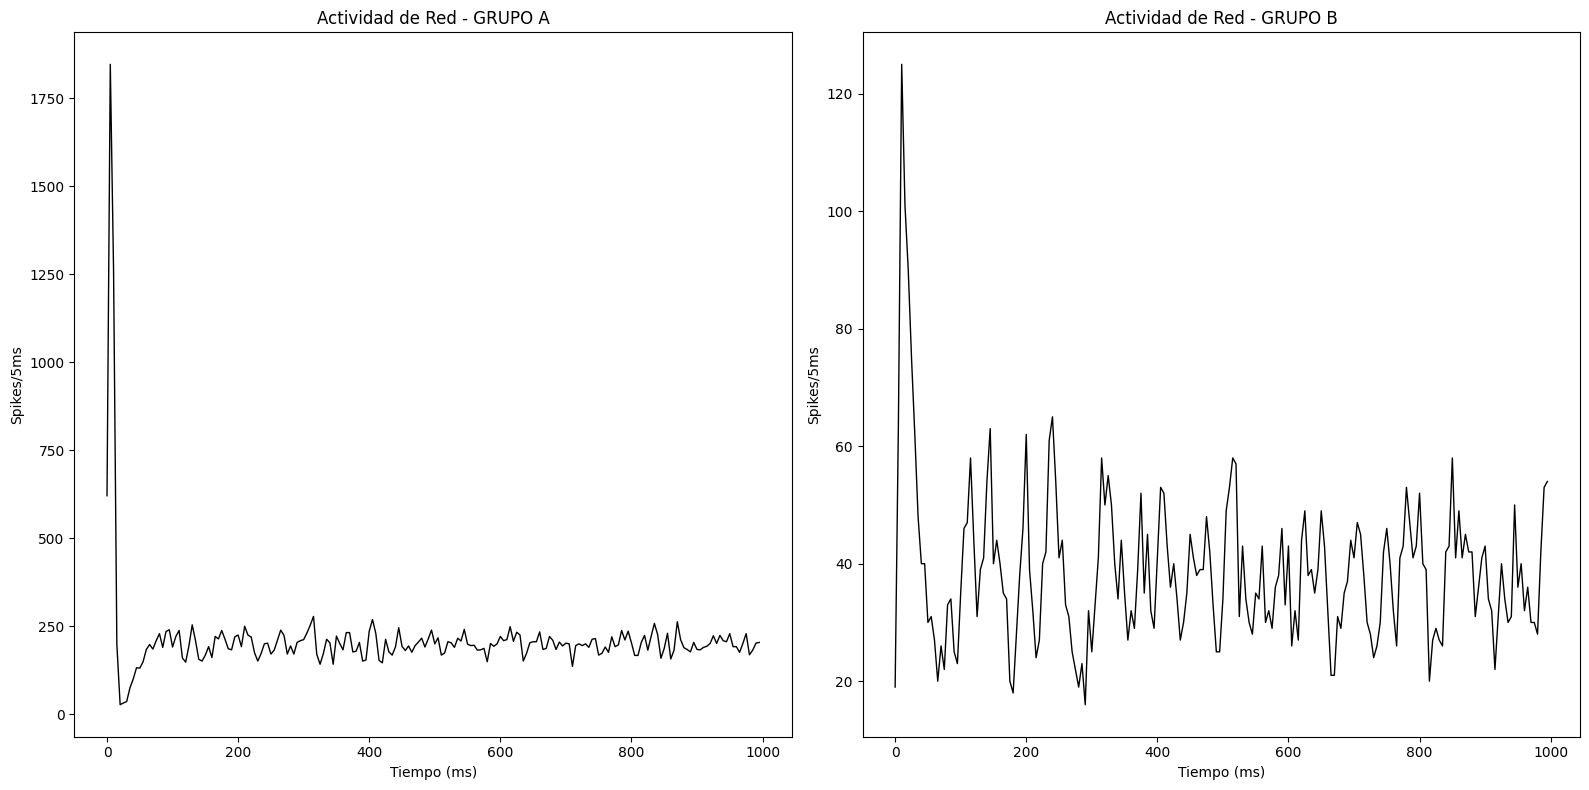

In [20]:
def plot_population_activity(results, bin_size_ms=5, T_total=1000):
   """Graficar actividad poblacional usando resultados de la red"""
   figure(figsize=(16, 8))

   time_bins = np.arange(0, T_total, bin_size_ms)

   # Grupo A
   subplot(1, 2, 1)
   spike_mon_A = results['A']['spike_monitor']
   spike_times_A = spike_mon_A.t/ms
   
   activity_A = []
   for t in time_bins:
       total_spikes = sum((spike_times_A >= t) & (spike_times_A < t + bin_size_ms))
       activity_A.append(total_spikes)

   plot(time_bins, activity_A, 'k-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel(f'Spikes/{bin_size_ms}ms')
   title('Actividad de Red - GRUPO A')

   # Grupo B
   subplot(1, 2, 2)
   spike_mon_B = results['B']['spike_monitor']
   spike_times_B = spike_mon_B.t/ms
   
   activity_B = []
   for t in time_bins:
       total_spikes = sum((spike_times_B >= t) & (spike_times_B < t + bin_size_ms))
       activity_B.append(total_spikes)

   plot(time_bins, activity_B, 'k-', linewidth=1)
   xlabel('Tiempo (ms)')
   ylabel(f'Spikes/{bin_size_ms}ms')
   title('Actividad de Red - GRUPO B')

   tight_layout()
   show()
   
plot_population_activity(results)

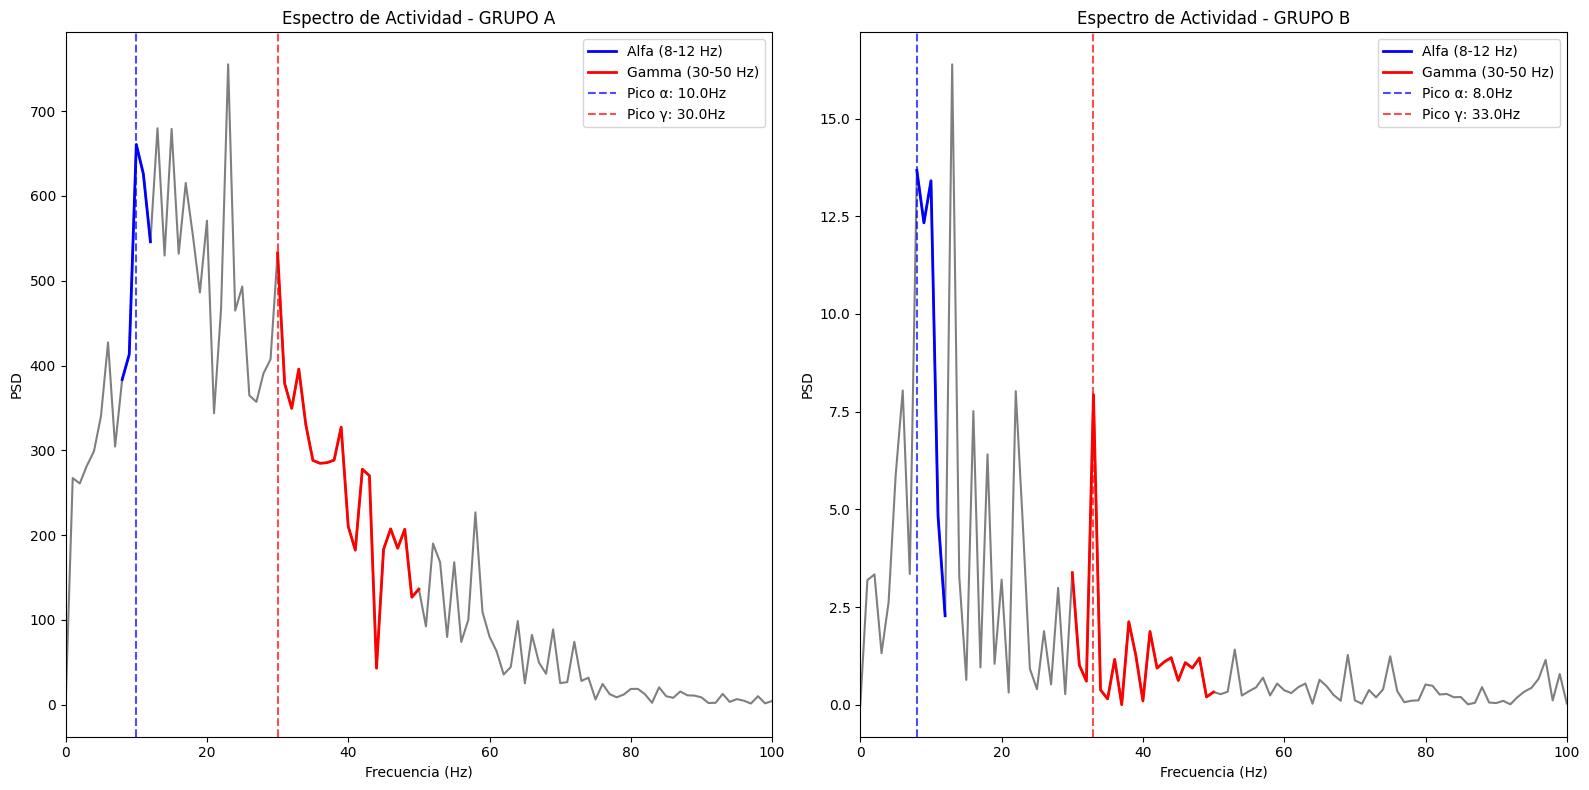

In [21]:
def plot_spectral_analysis(results, bin_size_ms=5, T_total=1000):
   """Análisis espectral de actividad poblacional"""
   from scipy import signal
   
   figure(figsize=(16, 8))
   time_bins = np.arange(0, T_total, bin_size_ms)
   
   # Calcular actividad para ambos grupos
   spike_mon_A = results['A']['spike_monitor']
   spike_times_A = spike_mon_A.t/ms
   activity_A = [sum((spike_times_A >= t) & (spike_times_A < t + bin_size_ms)) 
                 for t in time_bins]
   
   spike_mon_B = results['B']['spike_monitor']
   spike_times_B = spike_mon_B.t/ms
   activity_B = [sum((spike_times_B >= t) & (spike_times_B < t + bin_size_ms)) 
                 for t in time_bins]

   # Grupo A
   subplot(1, 2, 1)
   if len(activity_A) > 100:
       freqs, psd = signal.periodogram(activity_A, fs=1000/bin_size_ms)
       
       alpha_band = (freqs >= 8) & (freqs <= 12)
       gamma_band = (freqs >= 30) & (freqs <= 50)
       
       plot(freqs, psd, 'k-', alpha=0.5)
       plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
       plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
       
       if np.any(alpha_band) and np.any(gamma_band):
           alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
           gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
           axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
           axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')
       
       xlabel('Frecuencia (Hz)')
       ylabel('PSD')
       title('Espectro de Actividad - GRUPO A')
       xlim(0, 100)
       legend()

   # Grupo B
   subplot(1, 2, 2)
   if len(activity_B) > 100:
       freqs, psd = signal.periodogram(activity_B, fs=1000/bin_size_ms)
       
       alpha_band = (freqs >= 8) & (freqs <= 12)
       gamma_band = (freqs >= 30) & (freqs <= 50)
       
       plot(freqs, psd, 'k-', alpha=0.5)
       plot(freqs[alpha_band], psd[alpha_band], 'b-', linewidth=2, label='Alfa (8-12 Hz)')
       plot(freqs[gamma_band], psd[gamma_band], 'r-', linewidth=2, label='Gamma (30-50 Hz)')
       
       if np.any(alpha_band) and np.any(gamma_band):
           alpha_peak = freqs[alpha_band][np.argmax(psd[alpha_band])]
           gamma_peak = freqs[gamma_band][np.argmax(psd[gamma_band])]
           axvline(alpha_peak, color='blue', linestyle='--', alpha=0.7, label=f'Pico α: {alpha_peak:.1f}Hz')
           axvline(gamma_peak, color='red', linestyle='--', alpha=0.7, label=f'Pico γ: {gamma_peak:.1f}Hz')
       
       xlabel('Frecuencia (Hz)')
       ylabel('PSD')
       title('Espectro de Actividad - GRUPO B')
       xlim(0, 100)
       legend()

   tight_layout()
   show()
   
plot_spectral_analysis(results)

In [22]:
def print_network_statistics(results, network, N_exc=800, N_inh=200, bin_size_ms=5, T_total=1000):
   """Imprimir estadísticas de red usando objetos de la clase"""
   
   # Calcular actividad poblacional
   def calculate_activity(spike_monitor):
       spike_times = spike_monitor.t/ms
       time_bins = np.arange(0, T_total, bin_size_ms)
       return [sum((spike_times >= t) & (spike_times < t + bin_size_ms)) for t in time_bins]
   
   def calculate_frequencies(spike_monitor, N_exc):
       freq_exc = [sum(spike_monitor.i == i) for i in range(N_exc)]
       freq_inh = [sum(spike_monitor.i == (i + N_exc)) for i in range(N_inh)]
       return freq_exc, freq_inh
   
   N_total = N_exc + N_inh
   
   for pop_name in ['A', 'B']:
       spike_mon = results[pop_name]['spike_monitor']
       group = network.populations[pop_name]['group']
       syn_intra = network.populations[pop_name]['syn_intra']
       
       activity = calculate_activity(spike_mon)
       freq_exc, freq_inh = calculate_frequencies(spike_mon, N_exc)
       
       print(f"\n{'='*60}")
       print(f"COMPARACIÓN CON PAPER ORIGINAL - GRUPO {pop_name}")
       print(f"{'='*60}")
       
       print(f"Arquitectura:")
       print(f"  Neuronas: {N_exc} exc + {N_inh} inh (ratio 4:1 ✓)")
       print(f"  Conexiones: {len(syn_intra.i)} totales")
       print(f"  Prob. conexión: {len(syn_intra.i)/(N_total**2):.3f} (paper: ~0.09)")
       
       print(f"\nActividad:")
       exc_spikes = sum(spike_mon.i < N_exc)
       inh_spikes = sum(spike_mon.i >= N_exc)
       mean_freq_exc = exc_spikes / N_exc
       mean_freq_inh = inh_spikes / N_inh
       
       print(f"  Freq. excitatorias: {mean_freq_exc:.1f} Hz (paper: ~8Hz)")
       print(f"  Freq. inhibitorias: {mean_freq_inh:.1f} Hz")
       print(f"  Spikes totales: {exc_spikes + inh_spikes}")
       
       print(f"\nParámetros (verificación aleatoria):")
       idx_exc = np.random.randint(0, N_exc)
       idx_inh = np.random.randint(N_exc, N_total)
       print(f"  Neurona exc #{idx_exc}: c={group.c[idx_exc]:.1f}, d={group.d[idx_exc]:.1f}")
       print(f"  Neurona inh #{idx_inh}: a={group.a[idx_inh]:.3f}, b={group.b[idx_inh]:.3f}")
       
       print(f"\nComportamiento emergente:")
       asynchrony = np.std(activity) / np.mean(activity) if np.mean(activity) > 0 else 0
       print(f"  Índice asincronía: {asynchrony:.2f} (>1 = asíncrono ✓)")
       active_exc = sum(np.array(freq_exc) > 0)
       print(f"  Neuronas activas: {active_exc}/{N_exc} ({100*active_exc/N_exc:.1f}%)")
       
print_network_statistics(results, sim)


COMPARACIÓN CON PAPER ORIGINAL - GRUPO A
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 99776 totales
  Prob. conexión: 0.100 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 49.7 Hz (paper: ~8Hz)
  Freq. inhibitorias: 51.7 Hz
  Spikes totales: 50064

Parámetros (verificación aleatoria):
  Neurona exc #662: c=-59.5, d=5.8
  Neurona inh #878: a=0.022, b=0.249

Comportamiento emergente:
  Índice asincronía: 0.69 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)

COMPARACIÓN CON PAPER ORIGINAL - GRUPO B
Arquitectura:
  Neuronas: 800 exc + 200 inh (ratio 4:1 ✓)
  Conexiones: 100135 totales
  Prob. conexión: 0.100 (paper: ~0.09)

Actividad:
  Freq. excitatorias: 10.1 Hz (paper: ~8Hz)
  Freq. inhibitorias: 6.3 Hz
  Spikes totales: 9316

Parámetros (verificación aleatoria):
  Neurona exc #226: c=-50.8, d=2.3
  Neurona inh #887: a=0.039, b=0.238

Comportamiento emergente:
  Índice asincronía: 0.34 (>1 = asíncrono ✓)
  Neuronas activas: 800/800 (100.0%)


In [23]:
def extract_currents_info(results, network, population_name, N_exc=800):
   """Extraer estadísticas de corrientes usando objetos de la clase"""
   
   # Obtener monitores (necesitas añadirlos al setup_monitors)
   group = network.populations[population_name]['group']
   
   # Separar datos por tipo neuronal
   def separate_by_type(data):
       return data[:, :N_exc], data[:, N_exc:]  # exc, inh
   
   # Calcular estadísticas
   def calc_stats(data):
       return {
           'mean_per_neuron': np.mean(data, axis=0),
           'std_per_neuron': np.std(data, axis=0),
           'mean_per_timestep': np.mean(data, axis=1),
           'min_per_timestep': np.min(data, axis=1),
           'max_per_timestep': np.max(data, axis=1)
       }
   
   # Datos de corrientes (necesitas monitorearlos primero)
   I_thal = results[population_name]['I_thalamic']  # Añadir a get_results()
   I_syn = results[population_name]['I_syn']
   
   I_thal_exc, I_thal_inh = separate_by_type(I_thal)
   I_syn_exc, I_syn_inh = separate_by_type(I_syn)
   
   I_tot_exc = I_thal_exc + I_syn_exc
   I_tot_inh = I_thal_inh + I_syn_inh
   
   stats = {
       'thalamic_exc': calc_stats(I_thal_exc),
       'synaptic_exc': calc_stats(I_syn_exc),
       'total_exc': calc_stats(I_tot_exc),
       'thalamic_inh': calc_stats(I_thal_inh),
       'synaptic_inh': calc_stats(I_syn_inh),
       'total_inh': calc_stats(I_tot_inh)
   }
   
   print(f"=== Estadísticas del Grupo {population_name} ===")
   print("=== INPUT TALÁMICO ===")
   print(f"Brian2 exc - Media por neurona: {np.mean(stats['thalamic_exc']['mean_per_neuron']):.4f}")
   print(f"Brian2 exc - Std por neurona: {np.mean(stats['thalamic_exc']['std_per_neuron']):.4f}")
   
   print("\n=== INPUT SINÁPTICO ===")
   print(f"Brian2 exc - Media: {np.mean(stats['synaptic_exc']['mean_per_neuron']):.4f}")
   print(f"Brian2 exc - Std: {np.mean(stats['synaptic_exc']['std_per_neuron']):.4f}")
   print(f"Brian2 exc - Rango típico: [{np.mean(stats['synaptic_exc']['min_per_timestep']):.2f}, {np.mean(stats['synaptic_exc']['max_per_timestep']):.2f}]")
   
   return stats


stats_A = extract_currents_info(results, sim, 'A')
stats_B = extract_currents_info(results, sim, 'B')

=== Estadísticas del Grupo A ===
=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.4175
Brian2 exc - Std por neurona: 148.7504

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 2.2557
Brian2 exc - Std: 2.9491
Brian2 exc - Rango típico: [-2.23, 7.00]
=== Estadísticas del Grupo B ===
=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: 0.3499
Brian2 exc - Std por neurona: 49.6482

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8118
Brian2 exc - Std: 1.4438
Brian2 exc - Rango típico: [-1.17, 3.48]


== Estadísticas del Grupo A ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0019
Brian2 exc - Std por neurona: 4.9974

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8016
Brian2 exc - Std: 0.5017
Brian2 exc - Rango típico: [-4.84, 9.81]

=== Estadísticas del Grupo B ===

=== INPUT TALÁMICO ===
Brian2 exc - Media por neurona: -0.0039
Brian2 exc - Std por neurona: 5.0036

=== INPUT SINÁPTICO ===
Brian2 exc - Media: 0.8246
Brian2 exc - Std: 0.5066
Brian2 exc - Rango típico: [-4.62, 6.72]

In [ ]:
# Función para analizar resultados
def plot_two_population_results(results):
    """Graficar raster plots de ambas poblaciones"""
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Población A
    axes[0].plot(results['A']['spike_times'], results['A']['spike_indices'], 
                '.', markersize=0.5, color='black', alpha=0.7)
    axes[0].set_ylabel('Neurona A')
    axes[0].set_title(f'Red de Dos Poblaciones - dt = {results["dt"]} ms')
    axes[0].axhline(y=800, color='red', linestyle='--')
    
    # Población B
    axes[1].plot(results['B']['spike_times'], results['B']['spike_indices'], 
                '.', markersize=0.5, color='black')
    axes[1].set_ylabel('Neurona B')
    axes[1].set_xlabel('Tiempo (ms)')
    axes[1].axhline(y=800, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print(f"Spikes A: {len(results['A']['spike_times'])}")
    print(f"Spikes B: {len(results['B']['spike_times'])}")
    print(f"Rate A: {len(results['A']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")
    print(f"Rate B: {len(results['B']['spike_times'])/(results['T_total']*800)*1000:.2f} Hz")

: 